In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

- control is how we use the steering, throttle, and breaks to move a car where we want it to go
- control is a trickier problem than it might seem
- when human turns through an intersection, we use our intuition and experience to determine how hard to steer, when to accelerate, and whether we ever need to step on the brakes
  - teaching a computer how to do this is hard
- control algorithms are often called controllers, and one of the most common and fundamental controllers is the *PID controller*

# PID Control

- PID control is a vast field in control, and many, many classes can be taught about this one subject matter
- what I'll do is I'll give you the very basics, and I'll let you implement the very basics--you'll be able to drive a car around
- the Google car to the present day uses a version of this exact same controller that is, of course, much more tuned
- but you get to see some of the essence of what it means to control a car


- here is the problem--consider the following car with a steerable front axle and 2 non-steerable wheels in the back
- say we wished this car to drive along this line, which is the output of our smoothener
- let's assume the car has a fixed forward velocity, but you have the ability to set the steering angle of the car--how would you do this?
  - you would keep the steering constant?
  - you would use random steering commands?
  - you could set the steering angle in proportion to what's known as the *crosstrack error*, which is the lateral distance between the vehicle and the so-called reference trajectory
- you'll steer in proportion to the crosstrack error, which means the larger the error, the more you're willing to turn towards the target trajectory

<img src="resources/P_control_example.png"/>

- as you get closer to trajectory, your steering will be slower and slower and you will reach the trajectory
- a constant steering will put you in a circle and not in a straight line
- random steering, if you ever implement this, is a really bad idea

# Proportional Control

- what you just learned is called a *P-controller* where P stands for proportional


- here is a really trick question by which I want to test your intuition--one that doesn't have a unique answer, but it has a best answer
- **Q:** suppose you do what I just said-you steer in proportion to the crosstrack error, that is, your steering angle $\alpha$ is proportional by some factor of $\tau$ to the crosstrack error $\alpha = \tau \cdot \text{CTE}$--what will happen with the car?
- **A:** the car actually overshoots
  - the problem is no matter how small this constant $\tau$ is, it will eventually turns its wheels quite a bit towards it's trajectory
  - then it'll move towards a trajectory more and more, and when it hits it, it's wheels will be straight, but the robot itself will still be oriented a little bit downwards, so it's forced to overshoot
  - what this means is that applied to a car, a P-controller will act like this--it'll slightly overshoot, and that could be okay
  - the overshooting is very small but it'll never really converge
  - it'll be what's called "marginally stable" or often just "stable" in the literature.
  - <img src="resources/P_controller_marginally_stable.png"/>

# Implement P Controller

- I want you to implement such a controller
- here is the code I've prepared for you
  - there is a class `robot` with which has an `init`
  - you can set the position using the function `set`
  - there are `steering_noise` and `distance_noise`
  - there is also something called `drift` which you won't use right now, but later on it'll become handy
  - there is your `move` command
- I want you to implement the `run` command, which takes as input the control parameter that governs the proportional response of the steering angle to the crosstrack error
  - the robot has an initial position of $0, 1, 0,$ a speed of $1$, and I want to simulate it for $100$ steps and with the coefficient $0.1$ 
- here is what I envision to happen
  - your robot is initially off the the x axis by 1
  - I want it to drive along the x axis
  - the y value is the same as the cross track error
  - by turning, inversely proportional to the y value, using a parameter tau that sets the response strength of the proportional controller
  - I want the robot to turn towards the x axis, drive in that direction, overshoot, turn around, and drive back

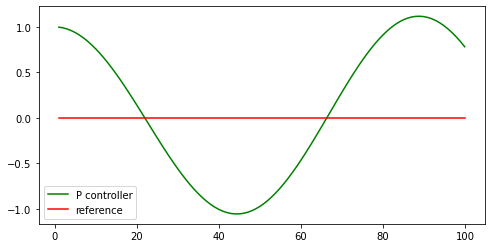

<IPython.core.display.Javascript object>

In [2]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
#
# this is the Robot class
#


class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return "[x=%.5f y=%.5f orient=%.5f]" % (self.x, self.y, self.orientation)


############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0)


def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.1)
n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="P controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

- the cross track error, `cte` is the current y position of the robot (our reference is a horizontal line) along the x-axis
- to get the steering value we multiply the `tau` parameter with the `cte`
- we then call the move method which causes the robot to move based on the `steer` and `speed` values
- add the x and y coordinates to the respective lists and then return them at the end

# Oscillations

- **Q:** If you modify the control parameter from $0.1$ to $0.3$, what happens?
- **A:** It'll oscillate faster.

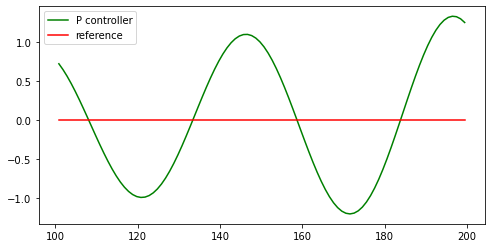

<IPython.core.display.Javascript object>

In [3]:
x_trajectory, y_trajectory = run(robot, 0.3)
n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="P controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

# PD Controller

- the basic next question is is there a way to void the overshoot?
- it would be nice if we could do this, because driving in an oscillating car is no fun
- the trick is called *PD-control*
- in PD-control my steering $\alpha$ is no just related to the crosstrack error by virtue of the gain parameter $\tau_p$, but also to the temporal derivative of the crosstrack error: $\alpha = -\tau_p \cdot \text{CTE} - \tau_d \dfrac{d}{dt} \text{CTE}$
- what this means is that when the car has turned enough to reduce the crosstrack error, it won't just go shooting for the x axis, but it will notice that it's already reducing the error so the error is becoming smaller over time
- it counter steers--it steers up again which will allow it to gracefully approach our target trajectory,  assuming appropriate settings of our differential gain--$\tau_d$ versus the proportional gain $\tau_p$
- how do you compute the derivative?
  - at time $t$ this is the same as the crosstrack error at time $t$ minus the crosstrack error at time $t-1$ divided by the time span between $t$ and $t-1$
  - in our code, we assume $\Delta t = 1$, so so we can omit this

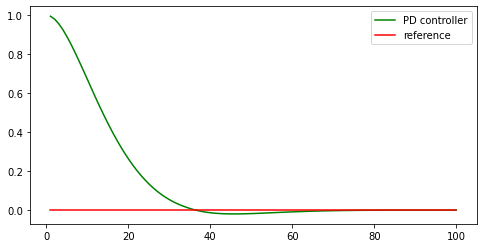

<IPython.core.display.Javascript object>

In [4]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau_p and tau_d so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
#
# Only modify code at the bottom! Look for the TODO
# ------------


############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

# previous P controller
def run_p(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


robot = Robot()
robot.set(0, 1, 0)


def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    prev_cte = robot.y
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0)
n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="PD controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

- this is very similar to the P controller
- we've added the `prev_cte` variable which is assigned to the previous CTE and `diff_cte`, the difference between the current CTE and previous CTE
- we then put it all together with the new `tau_d` parameter to calculate the new steering value, `-tau_p * cte - tau_d * diff_cte`

# Systematic Bias

- let's talk about a problem that often occurs in robotics called a *systematic bias*
- when you ordered your car, you believed the front wheels were 100% aligned, but your mechanic made a mistake, and he aligned the wheels a little bit at an angle
- now, for people that isn't a big concern--when we notice this we just steer a little bit stronger
- but let's try this out with out our proportional controller


- I'm now adding a line that sets the steering drift to be 10 degrees
- **Q:** What happens when you run my proportional controller with parameter 0.2, and the differential controller set to 0?
- **A:** Causes a big CTE. Even though the bias was in steering, it manifests itself as an increased crosstrack error in the y direction.

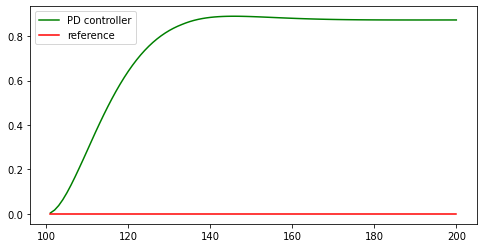

<IPython.core.display.Javascript object>

In [5]:
from math import pi

robot.set_steering_drift(10.0 / 180.0 * pi)  # 10 degrees

x_trajectory, y_trajectory = run(robot, 0.2, 3.0)
n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="PD controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

# Is PD Enough

- **Q** Can the differential term, or D-term, solve this problem?
- **A:** No. Let us try this out. Let's enter a 3.0 for the differential term, run everything, and the y error is still large.

# PID implementation

- if you drive a car and your normal steering mode leads you to a trajectory far away from the goal, you notice over a long period of time you can't get closer
- so you start steering more and more the more time goes by to the right (to the goal) to compensate this bias
- as a result, when you drive you steer the car this way (to the goal) to do so, you need a sustained situation of large error
- that's measured by the integral or the sum of the crosstrack errors over time


- let's make a new controller where steering is proportional to the crosstrack errors before, it's equally proportional to the differential of the crosstrack error, but now it's also proportional to what's called the integral or the sum of all the crosstrack errors you ever observed: $\alpha = -\tau_p \cdot \text{CTE} - \tau_d \dfrac{d}{dt} \text{CTE} - \tau_i \cdot \sum \text{CTE}$
  - if we have a constant crosstrack error of, say, $0.8$ and the sum will increase by $0.8$ for each time unit, it'll become larger and larger and larger, and eventually it'll correct the robot's motion
  - this is called the PID controller
    - **P** or the **proportional term**
    - **D** or the **differential term**
    - **I** for the **integral**


- let's implement this in our code
- I'll give you an integral factor of $0.004$ (let's not worry why I picked those--they're actually wisely chosen)

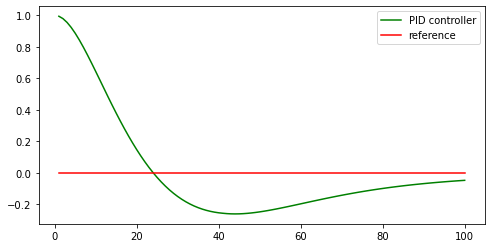

<IPython.core.display.Javascript object>

In [6]:
# -----------
# User Instructions
#
# Implement a PID controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Only modify code at the bottom! Look for the TODO.
# ------------


############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

robot = Robot()
robot.set(0, 1, 0)


def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="PID controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

- with the integral term we're keeping track of all the previous CTEs, initially we set `int_cte` to $0$ and then add the current `cte` term to the count `int_cte += cte`
- finally we update the steering value, `-tau_p * cte - tau_d * diff_cte - tau_i * int_cte` with the new `tau_i` parameter


- this may not seem all that impressive
- PID seems to do worse than the PD controller!
- the purpose of the I-term is to compensate for biases, and the current robot has no bias

# Twiddle

- how can we find good control gains where control gains are these parameters $\tau_p$, $\tau_d$ and $\tau_i$
- the answer is so called *twiddle*--some people call it *coordinate ascent*
- in Twiddle, we're trying to optimize for a set of parameters
  - to do so, our function `run()` must return a goodness
    - this goodness value might be the average crosstrack error


- say I wanted to implement Twiddle to minimize the average crosstrack error
  - if that's the case, then the output of `run()` depends on the three parameters
- here's how Twiddle works:
  - build a parameter vector `p` of our 3-target parameters, and initialize it with $0$
  - also, build a vector of potential changes `dp` that you want to probe and initialize them for now with $1$
  - then you can run our command `run()` with our parameters, and whatever it outputs is our best error so far
  - now we wish to modify `p` as to make the error smaller
  - that's where Twiddle comes in
    - we sequentially go through these parameters
    - first we tried to increase `p` by our probing value, compute a new error for this new modified `p`
    - if this new error is better than our best error, then we do two things
      - we set `best_err` to `err`
      - we modify our `dp` to a slightly larger value by multiplying it with $1.1$
    - otherwise, we try the other way
      - we subtract `dp` from `p`--and we have to do it twice now because we added it before
    - if both of those fail we set `p[i]` back to the original value, and we decrease our probing value--say, by multiplying it with $0.9$


- that's the core of Twiddle, and what it really does is for each coordinate in isolation it moves our parameter down a little bit by some value
- if it then finds a better solution, it retains it, and it even increments the probing interval
- if it fails to find a better solution, it goes back to the original and decreases our probing interval
- we do this entire thing so long as the sum of the dp's is larger than the threshold
- it's local hill climber, but it happens to be really, really efficient

<img src="resources/twiddle.png"/>

# Parameter Optimization

Iteration 0, best error = 8315.955485215645
Iteration 1, best error = 0.0434970807256939
Iteration 2, best error = 0.03065437362443958
Iteration 3, best error = 0.007677320020068962
Iteration 4, best error = 0.0032201674271162446
Iteration 5, best error = 0.0016645945527960435
Iteration 6, best error = 0.0009761080831682494
Iteration 7, best error = 0.0006163432367765914
Iteration 8, best error = 0.00041102748054356214
Iteration 9, best error = 0.00019877374116068796
Iteration 10, best error = 1.176902590931792e-06
Iteration 11, best error = 7.050884269315375e-07
Iteration 12, best error = 1.379736668887161e-12
Iteration 13, best error = 1.379736668887161e-12
Iteration 14, best error = 1.379736668887161e-12
Iteration 15, best error = 1.0756081254419683e-12
Iteration 16, best error = 1.0756081254419683e-12
Iteration 17, best error = 1.0756081254419683e-12
Iteration 18, best error = 8.12857772854578e-13
Iteration 19, best error = 8.12857772854578e-13
Iteration 20, best error = 8.12857772

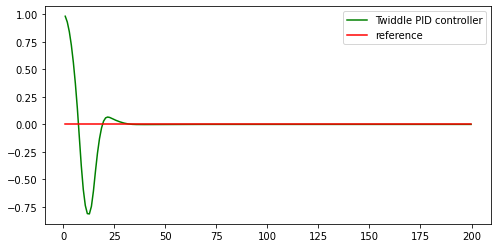

<IPython.core.display.Javascript object>

In [7]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# You don't have to use the exact values as shown in the video
# play around with different values! This quiz isn't graded just see
# how low of an error you can get.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
#
# No cheating!
# ------------


############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):  # set to 2n to see better how algorithm converges
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2):
    # Don't forget to call `make_robot` before every call of `run`!
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)
    # TODO: twiddle loop here
    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1

    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, "g", label="Twiddle PID controller")
ax1.plot(x_trajectory, np.zeros(n), "r", label="reference")
ax1.legend()

# Additional Resources on Control

- nice work reaching the end of the control content!
- while you still have the project left to do here, we're also providing some additional resources and recent research on the topic that you can come back to if you have time later on


- all of these are completely optional reading - you could spend hours reading through the entirety of these!
- we suggest moving onto the project first so you have what you’ve learned fresh on your mind, before coming back to check these out


- we've categorized these papers to hopefully help you narrow down which ones might be of interest, as well as including their Abstract section, which summarizes the paper

## Model Predictive Control (MPC)

Vision-Based High Speed Driving with a Deep Dynamic Observer by P. Drews, et. al. https://arxiv.org/abs/1812.02071

***Abstract:*** *In this paper we present a framework for combining deep learning-based road detection, particle filters, and Model Predictive Control (MPC) to drive aggressively using only a monocular camera, IMU, and wheel speed sensors. This framework uses deep convolutional neural networks combined with LSTMs to learn a local cost map representation of the track in front of the vehicle. A particle filter uses this dynamic observation model to localize in a schematic map, and MPC is used to drive aggressively using this particle filter based state estimate. We show extensive real world testing results, and demonstrate reliable operation of the vehicle at the friction limits on a complex dirt track. We reach speeds above 27 mph (12 m/s) on a dirt track with a 105 foot (32m) long straight using our 1:5 scale test vehicle. [...]*

## Reinforcement Learning-based

Reinforcement Learning and Deep Learning based Lateral Control for Autonomous Driving by D. Li, et. al. https://arxiv.org/abs/1810.12778

***Abstract:*** *This paper investigates the vision-based autonomous driving with deep learning and reinforcement learning methods. Different from the end-to-end learning method, our method breaks the vision-based lateral control system down into a perception module and a control module. The perception module which is based on a multi-task learning neural network first takes a driver-view image as its input and predicts the track features. The control module which is based on reinforcement learning then makes a control decision based on these features. In order to improve the data efficiency, we propose visual TORCS (VTORCS), a deep reinforcement learning environment which is based on the open racing car simulator (TORCS). By means of the provided functions, one can train an agent with the input of an image or various physical sensor measurement, or evaluate the perception algorithm on this simulator. The trained reinforcement learning controller outperforms the linear quadratic regulator (LQR) controller and model predictive control (MPC) controller on different tracks. The experiments demonstrate that the perception module shows promising performance and the controller is capable of controlling the vehicle drive well along the track center with visual input.*

## Behavioral Cloning

The below paper shows one of the techniques Waymo has researched using imitation learning (aka behavioral cloning) to drive a car.

ChauffeurNet: Learning to Drive by Imitating the Best and Synthesizing the Worst by M. Bansal, A. Krizhevsky and A. Ogale https://arxiv.org/abs/1812.03079

***Abstract:*** *Our goal is to train a policy for autonomous driving via imitation learning that is robust enough to drive a real vehicle. We find that standard behavior cloning is insufficient for handling complex driving scenarios, even when we leverage a perception system for preprocessing the input and a controller for executing the output on the car: 30 million examples are still not enough. We propose exposing the learner to synthesized data in the form of perturbations to the expert's driving, which creates interesting situations such as collisions and/or going off the road. Rather than purely imitating all data, we augment the imitation loss with additional losses that penalize undesirable events and encourage progress -- the perturbations then provide an important signal for these losses and lead to robustness of the learned model. We show that the ChauffeurNet model can handle complex situations in simulation, and present ablation experiments that emphasize the importance of each of our proposed changes and show that the model is responding to the appropriate causal factors. Finally, we demonstrate the model driving a car in the real world.*